# 2D CFD Simulations #

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

## Steady State Heat Diffusion in Square Plate

- Governing Equation: ∂²T/∂x² + ∂²T/∂y² = ∇²T = 0
- Boundary Condition: T(x=0) = 100, T(y=0) = T(y=100) = T(x=100) = 0

- Discretized: T(i,j) = ( T(i-1,j-1) + T(i+1,j-1) + T(i-1,j+1) + T(i+1,j+1) ) / 4

- Can use a simple 5-point Iterative Stencil Loop due to local PDE discretization
- Convergence is achieved with increasing iterations

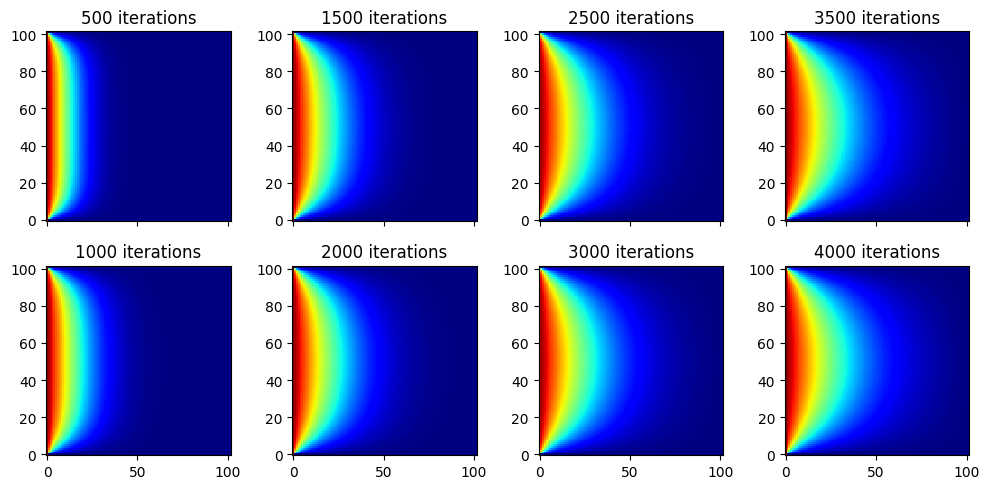

In [10]:
# grid size
x_size = 100
y_size = 100

# Note: index 0 and -1 are outside edges 
T = np.zeros((y_size+2, x_size+2))
T[1:x_size+1, 0] = 100

# define plots
fig, ax = plt.subplots(2, 4, sharex=True, figsize=(10, 5))

# iteration to convergence, with intermediate plotting every 800 iterations
for i in range(8):

    for j in range(500):
        # Tn stores values from previous iteration, used to obtain new T
        Tn = T.copy()   

        # 5-point stencil method (2D) - only for special cases of local PDE discretizations
        T[1:-1, 1:-1] = (Tn[0:-2, 1:-1] + Tn[2:, 1:-1] + Tn[1:-1, 0:-2] + Tn[1:-1, 2:]) / 4

        T[0, :] = 0
        T[-1, :] = 0
        T[:, 0] = 100
        T[:, -1] = 0
        
    axi = ax[i%2][i//2]
    axi.set_title(f"{(i+1)*500} iterations")
    axi.pcolormesh(range(x_size+2), range(y_size+2), T, cmap="jet")

fig.tight_layout()  # ensures title and subplots are properly spaced with no overlaps
plt.show() # shows progressively converging temperature distribution in the plate


## Nonlinear Convection ##

- Governing Equations: 
    - ∂u/∂t + u(∂u/∂x) + v(∂u/∂y) = 0
    - ∂v/∂t + u(∂v/∂x) + v(∂v/∂y) = 0
- Discretized Equations:
    - ( u(i,j,n+1) - u(i,j,n) ) / dt + u(i,j,n) ( u(i,j,n) - u(i-1,j,n) ) / dx + v(i,j,n) ( u(i,j,n) - u(i,j-1,n) ) / dy = 0
    - ( v(i,j,n+1) - v(i,j,n) ) / dt + u(i,j,n) ( v(i,j,n) - v(i-1,j,n) ) / dx + v(i,j,n) ( v(i,j,n) - v(i,j-1,n) ) / dy = 0
    - can express unknown (n+1)th time u(i,j,n+1) and v(i,j,n+1) as function of known nth time u and v
- Initial Conditions: 
    - u, v = 2 for x,y ∈ (0.5,1)×(0.5,1)
    - u, v = 1 everywhere else
- Boundary Conditions:
    - u, v = 1 for x=0,2, y=0,2
- Reference: https://lorenabarba.com/blog/cfd-python-12-steps-to-navier-stokes/

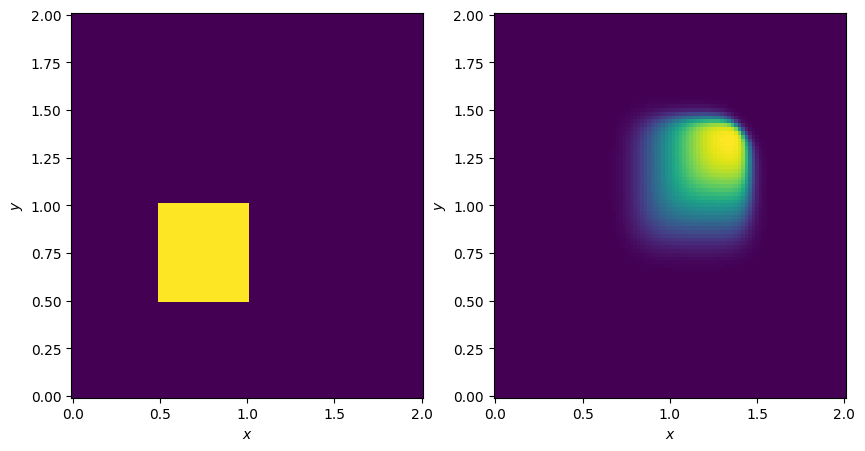

In [ ]:
# grid size
x_size = 2
y_size = 2

# number of grid points
nx = 101
ny = 101
nt = 80

# step size
dx = x_size / (nx - 1)
dy = y_size / (ny - 1)
sigma = 0.2
dt = sigma * dx

# grid velocity values setup
u = np.ones((nx, ny))   # current u velocity (n+1)
v = np.ones((nx, ny))   # current v velocity (n+1)

# initial conditions (square hat function)
u[int(0.5/dy) : int(1/dy+1), int(0.5/dx) : int(1/dx+1)] = 2
v[int(0.5/dy) : int(1/dy+1), int(0.5/dx) : int(1/dx+1)] = 2

# setup figure meshgrid and axes
fig, (ax_initial, ax_final)= plt.subplots(nrows=1, ncols=2, figsize=(10, 5), dpi=100)
ax = fig.gca()
x = np.linspace(0, 2, nx)
y = np.linspace(0, 2, ny)
X, Y = np.meshgrid(x, y)

# plot initial
ax_initial.pcolormesh(X, Y, u, cmap=cm.viridis)
ax_initial.set_xlabel('$x$')
ax_initial.set_ylabel('$y$')

# time advancement - stencil method
for i in range(nt):
    un = u.copy()
    vn = v.copy()
    u[1:-1, 1:-1] = un[1:-1, 1:-1] \
                    - (dt/dx)*un[1:-1, 1:-1]*(un[1:-1, 1:-1] - un[1:-1, 0:-2]) \
                    - (dt/dy)*vn[1:-1, 1:-1]*(un[1:-1, 1:-1] - un[0:-2, 1:-1])
    v[1:-1, 1:-1] = vn[1:-1, 1:-1] \
                    - (dt/dx)*un[1:-1, 1:-1]*(vn[1:-1, 1:-1] - vn[1:-1, 0:-2]) \
                    - (dt/dy)*vn[1:-1, 1:-1]*(vn[1:-1, 1:-1] - vn[0:-2, 1:-1])

# plot final
ax_final.pcolormesh(X, Y, u, cmap=cm.viridis)
ax_final.set_xlabel('$x$')
ax_final.set_ylabel('$y$')
plt.show()

Alternatively, using matrix assembly approach
- see matrix_assy.py and linear_solvers.py (in progress)

## Lid-Driven Cavity Flow ##
- Governing Equations (NS equations with no gravity): 
    - ∂u/∂t + u(∂u/∂x) + v(∂u/∂y) = -(1/ρ)(∂P/∂x) + 𝜈(∂²u/∂x² + ∂²u/∂y²)
    - ∂v/∂t + u(∂v/∂x) + v(∂v/∂y) = -(1/ρ)(∂P/∂y) + 𝜈(∂²v/∂x² + ∂²v/∂y²)
- Discretized Equations:
    - t
- Initial Conditions:
    - u, v, p = 0 everywhere
- Boundary Conditions:
    - u, v = 0  at x=0, y=0, y=2 (walls)
    - u = 2     at y=2 (lid)
    - P = 0     at y=2 (lid)
    - ∂P/∂x = 0 at x=0, x=2
    - ∂P/∂y = 0 at y=0